In [2]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import time 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [3]:
SEQ_LEN = 200
COIN_TO_PRED = 'BIT'
EPOCHS = 10
BATCH_SIZE = 32
NAME = f"{COIN_TO_PRED}-COIN-{SEQ_LEN}-SEQ-{int(time.time())}"

In [4]:

df = pd.read_csv("D:/college/Extra/Intern/iisc/LSTM/crypto_data_c/dataset.csv", names=['number', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'time', 'crypto_name', 'date'])

df = df.drop(['marketCap', 'time', 'number'], axis = 1)

feature_order = ['date', 'low', 'high', 'open', 'close', 'volume', 'crypto_name']

df = df.reindex(columns=feature_order)

df_BIT = df.groupby(df.crypto_name).get_group('Bitcoin')

df_BIT.to_csv("D:/college/Extra/Intern/iisc/LSTM/crypto_data_c/BIT.csv", header=False)

crypto_names =['Litecoin', 'XRP', 'Dogecoin', 'Ethereum']
short = ['LIT', 'XRP', 'DOG', 'ETH']

for cn, sf in zip(crypto_names, short):
    df_new = df.groupby(df.crypto_name).get_group(cn)
    df_new.to_csv(f"D:/college/Extra/Intern/iisc/LSTM/crypto_data_c/{sf}.csv", header=False)

In [5]:
coins = ['BIT', 'LIT', 'XRP', 'DOG', 'ETH']
final_df = pd.DataFrame()
for s in coins:
    dataset = f"D:/college/Extra/Intern/iisc/LSTM/crypto_data_c/{s}.csv"
    df_temp = pd.read_csv(dataset, names = ['date', 'low', 'high','open', 'close', 'volume', 'crypto_name'])
    df_temp.rename(columns = {'close':f"{s}_close", 'volume':f"{s}_volume"}, inplace = True)
    df_temp.set_index('date', inplace=True)
    df_new = df_temp[[f"{s}_close", f"{s}_volume"]]
    
    if len(final_df) == 0:
        final_df = df_new
    else:
        final_df = final_df.join(df_new)

final_df.fillna(method="ffill", inplace=True) 
final_df = final_df.dropna()
final_df.to_csv("D:/college/Extra/Intern/iisc/LSTM/crypto_data_c/struct_ds.csv")

final_df

C:\Users\Srivageesh Srinidhi\AppData\Local\Temp\ipykernel_11560\3711019988.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df.fillna(method="ffill", inplace=True)


,BIT_close,BIT_volume,LIT_close,LIT_volume,XRP_close,XRP_volume,DOG_close,DOG_volume,ETH_close,ETH_volume
date,,,,,,,,,,
07-08-2015,279.584992,4.248480e+07,4.208280,4192810.0,0.008152,3.636430e+05,0.000168,1.004920e+05,2.772120,1.643290e+05
08-08-2015,260.997009,5.853300e+07,3.854750,4917730.0,0.008476,6.782950e+05,0.000158,1.452280e+05,0.753325,6.741880e+05
09-08-2015,265.083008,2.378960e+07,3.898590,3064680.0,0.008808,5.319690e+05,0.000162,1.064000e+05,0.701897,5.321700e+05
10-08-2015,264.470001,2.097940e+07,3.948880,2239890.0,0.008750,4.729730e+05,0.000160,6.811180e+04,0.708448,4.052830e+05
11-08-2015,270.385986,2.543390e+07,4.159550,3426300.0,0.008591,2.824610e+05,0.000164,1.218840e+05,1.067860,1.463100e+06
...,...,...,...,...,...,...,...,...,...,...
25-09-2022,18802.097980,2.335997e+10,52.632001,385124911.9,0.492627,3.422192e+09,0.061152,3.674540e+08,1294.216774,1.180265e+10
02-10-2022,19044.107270,2.076596e+10,51.911633,270394847.6,0.448850,1.524149e+09,0.059288,1.981684e+08,1276.093558,7.578352e+09
09-10-2022,19446.426190,1.683726e+10,53.910038,255019662.2,0.534061,1.789207e+09,0.062156,1.582803e+08,1322.604300,5.486230e+09


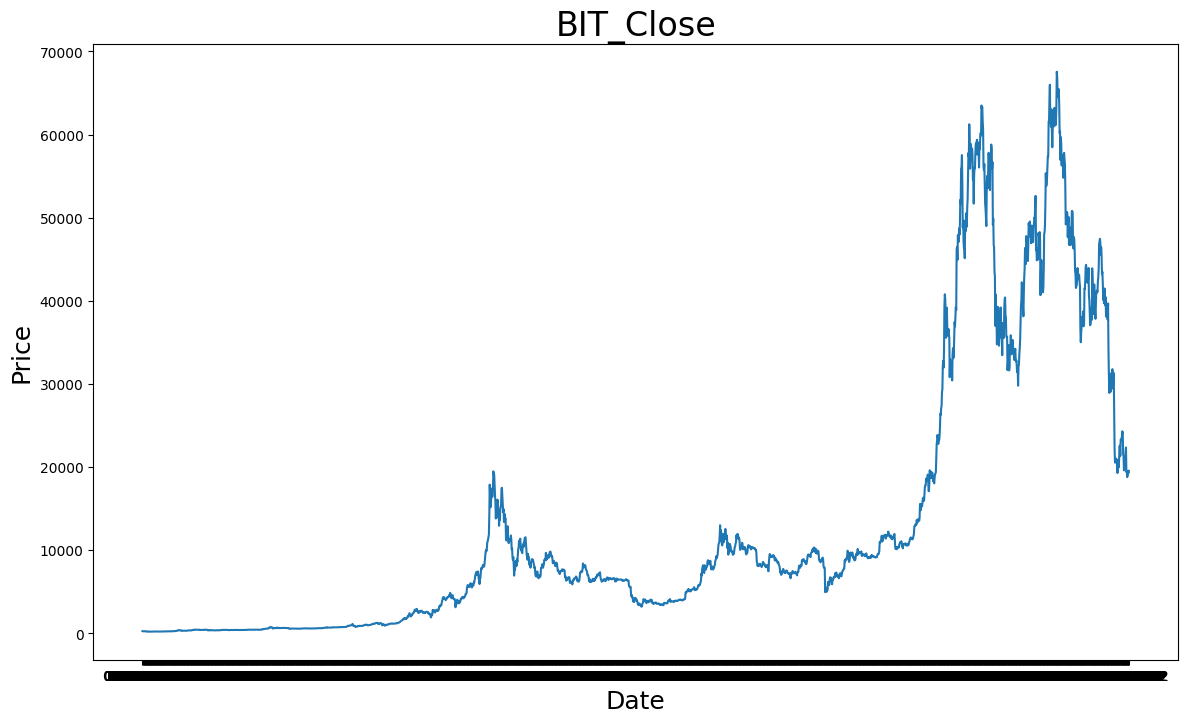

In [6]:
plt.figure(figsize=(14,8))
plt.title(f"{COIN_TO_PRED}_Close", fontsize=24)
plt.plot(final_df[f"{COIN_TO_PRED}_close"])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

In [7]:
data = final_df.filter([f"{COIN_TO_PRED}_close"])
dataset = data.values
len_train = int(np.ceil(len(dataset) * 0.8))
len_train

1940

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00102574],
       [0.00074977],
       [0.00081044],
       ...,
       [0.28558459],
       [0.28293698],
       [0.28737479]])

In [9]:
scaled_data_df = pd.DataFrame(scaled_data, columns=['BIT_close'])
scaled_data_df

,BIT_close
0,0.001026
1,0.000750
2,0.000810
3,0.000801
4,0.000889
...,...
2419,0.276019
2420,0.279612
2421,0.285585
2422,0.282937


In [10]:
train_data = scaled_data[0:len_train, :]
train_x= []
train_y = []

for i in range(SEQ_LEN, len(train_data)):
  train_x.append(train_data[i-SEQ_LEN: i, 0])
  train_y.append(train_data[i, 0])

print(len(train_x))

train_x, train_y = np.array(train_x), np.array(train_y)

1740


In [10]:
train_x.shape

(1740, 200)

In [11]:
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1)) 
train_x.shape

(1740, 200, 1)

In [12]:
len(train_y)

1740

In [13]:

test_data = scaled_data[len_train - SEQ_LEN : , :]

test_x = []
test_y = dataset[len_train : , :]
for i in range(SEQ_LEN, len(test_data)):
  test_x.append(test_data[i-SEQ_LEN : i, 0])

In [14]:
test_x = np.array(test_x)

In [15]:
test_x.shape[0]

484

In [16]:
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
test_x.shape

(484, 200, 1)

In [17]:
train_x.shape[1:]

(200, 1)

In [18]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mse')

c:\Users\Srivageesh Srinidhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=24)

Epoch 1/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0657
Epoch 2/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0139
Epoch 3/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0095
Epoch 4/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0055
Epoch 5/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0030
Epoch 6/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0017
Epoch 7/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0017
Epoch 8/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0010
Epoch 9/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0019
Epoch 10/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0019
Epoch 11/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0010
Epoch 12/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 9.2004e-04
Epoch 13/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 7.9239e-04
Epoch 14/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 7.3042e-04
Epoch 15/24
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss:

In [20]:
model.save("D:/college/Extra/Intern/iisc/LSTM/crypto_data_c/weights_finalish.keras")

In [21]:
predictions = model.predict(train_x)
predictions.shape

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


(1740, 1)

In [22]:
len(train_y)
train_y.shape

(1740,)

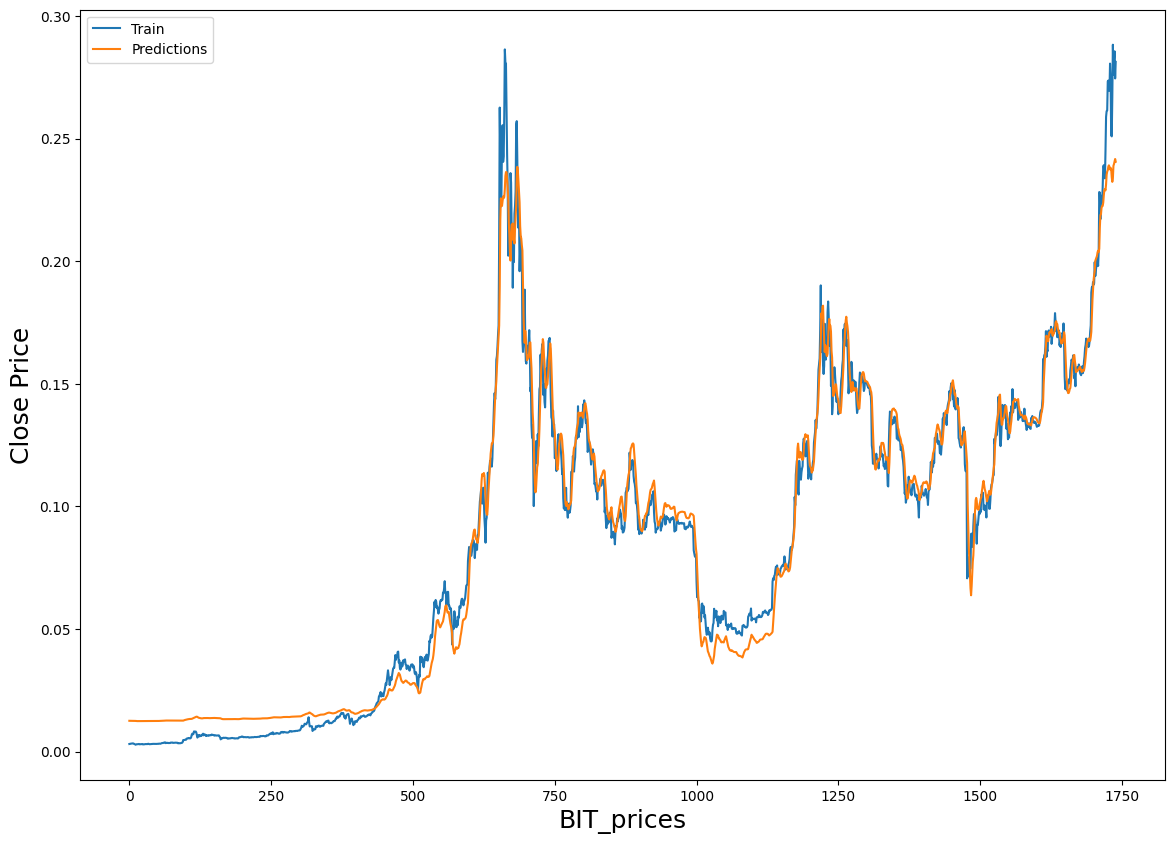

In [23]:
plt.figure(figsize=(14, 10))
plt.xlabel(f'{COIN_TO_PRED}_prices', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train_y)
plt.plot(predictions)

plt.legend(['Train', 'Predictions'], loc='upper left')

In [24]:
# plot_train_y = train_y[len(train_y)-SEQ_LEN:]
# plot_train_y.shape

In [25]:
predictions = model.predict(test_x)
predictions.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


(484, 1)

In [26]:
train = scaled_data_df[:len_train]

validation = scaled_data_df[len_train:]
validation['Predictions'] = predictions
train

C:\Users\Srivageesh Srinidhi\AppData\Local\Temp\ipykernel_17140\2187025165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


,BIT_close
0,0.001026
1,0.000750
2,0.000810
3,0.000801
4,0.000889
...,...
1935,0.276032
1936,0.281942
1937,0.285569
1938,0.274499


In [27]:
validation

,BIT_close,Predictions
1940,0.284081,0.240750
1941,0.281802,0.241155
1942,0.268878,0.241008
1943,0.272334,0.239285
1944,0.268045,0.239015
...,...,...
2419,0.276019,0.244974
2420,0.279612,0.242001
2421,0.285585,0.241561
2422,0.282937,0.243132


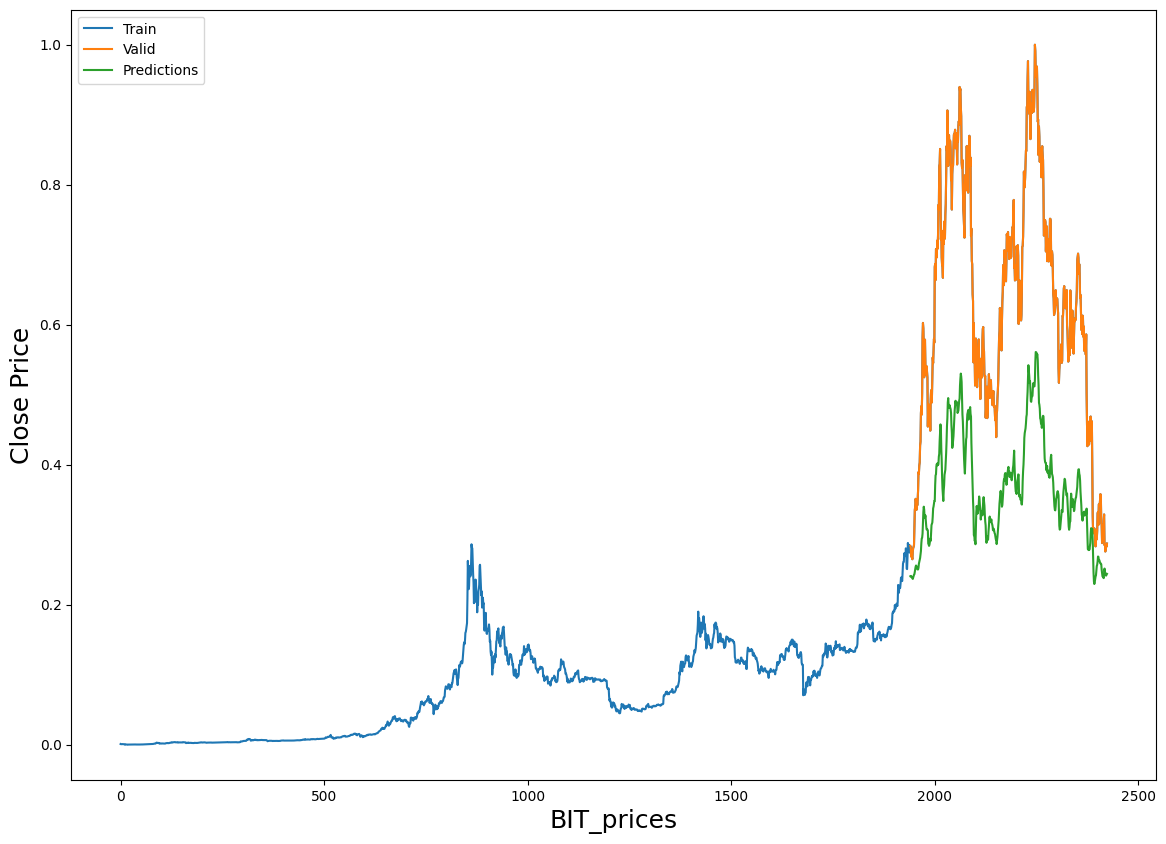

In [28]:
plt.figure(figsize=(14, 10))
plt.xlabel(f'{COIN_TO_PRED}_prices', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(scaled_data_df[f'{COIN_TO_PRED}_close'])
plt.plot(validation[[f'{COIN_TO_PRED}_close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')